<a href="https://colab.research.google.com/github/navneetkrc/Colab_fastai/blob/master/KYC_multimodels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Implemented using FASTAI V1

In [0]:
# To determine which version you're using:
!pip show tensorflow

# For the current version: 
!pip install --upgrade tensorflow

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

In [0]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html

In [0]:
import torch
print(torch.__version__)
!pip install torchtext==0.2.3
!pip install Pillow==4.0.0
!pip install PIL
!pip install image

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [0]:
!pip install fastai

In [0]:
from fastai import *
from fastai.vision import *
import pandas as pd 

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [0]:
bs = 16

#  KYC Image Dataset

## Looking at the data

###Getting Dataset from Google

Data is downloaded from Google Images using the chrome extension Fatkun Image Downloader and ensured manually that we have clean data

In [0]:
!mkdir data
!unzip KYC.zip -d data

In [9]:
"""
from PIL import Image 
import glob, os
directory = "content/data"
for infile in glob.glob("*.png"):
    file, ext = os.path.splitext(infile)
    im = Image.open(infile)
    rgb_im = im.convert('RGB')
    rgb_im.save(directory + file + ".jpg", "JPG")
for infile in glob.glob("*.PNG"):
    file, ext = os.path.splitext(infile)
    im = Image.open(infile)
    rgb_im = im.convert('RGB')
    rgb_im.save(directory + file + ".jpg", "JPG") 
"""

'\nfrom PIL import Image \nimport glob, os\ndirectory = "content/data"\nfor infile in glob.glob("*.png"):\n    file, ext = os.path.splitext(infile)\n    im = Image.open(infile)\n    rgb_im = im.convert(\'RGB\')\n    rgb_im.save(directory + file + ".jpg", "JPG")\nfor infile in glob.glob("*.PNG"):\n    file, ext = os.path.splitext(infile)\n    im = Image.open(infile)\n    rgb_im = im.convert(\'RGB\')\n    rgb_im.save(directory + file + ".jpg", "JPG") \n'

###Setting the path for data

We are going to use the dataset downloaded and cleaned from Google Image search 
and we start with 5 classes:-

1.   AADHAR
2.   DL
3.   PAN CARD
4.   PASSPORT
5.   VOTER ID




Our model will need to learn to differentiate between these 5 distinct categories. 
We use **FASTAI-V1** model to get the results.

In [10]:
path='data/KYC/'
os.listdir('data/KYC')

['VOTER ID', 'AADHAR', 'PASSPORT', 'DL', '.DS_Store', 'PAN CARD']

###Loading and Understanding the Data
The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data, means **understanding how the data directories are structured**, what the **labels** are and what some **sample images** look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, **5 labels**are stored based on the folders.

Fortunately, the fastai library has a handy function made exactly for this.

[Image data from folder ](https://docs.fast.ai/vision.data.html#ImageDataBunch.from_folder).

##Loading Labels [From_Folders](https://github.com/fastai/fastai/blob/master/fastai/vision/data.py#L108)

from_folder(path:PathOrStr, train:PathOrStr='train', valid:PathOrStr='valid', valid_pct=None, classes:Collection=None, kwargs:Any) → ImageDataBunch

Create from imagenet style dataset in path with train,valid,test subfolders (or provide valid_pct).

"Imagenet-style" datasets look something like this (note that the test folder is optional):

**File Structure**

path\

    KYC\
        AADHAR\
        DL\
        PAN CARD\
        ...

In [0]:
tfms = get_transforms(do_flip=True)
data = (ImageItemList.from_folder(path)
        .random_split_by_pct()
        .label_from_folder()
        .transform(tfms, size=224)
        .databunch())

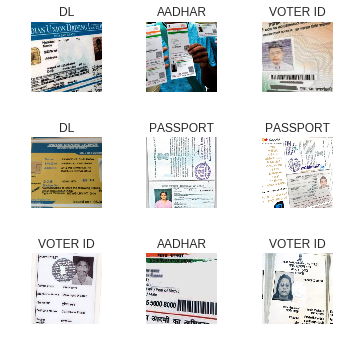

In [12]:
data.show_batch(rows=3, figsize=(5,5))

In [73]:
print(data.classes)
len(data.classes),data.c

['AADHAR', 'DL', 'PAN CARD', 'PASSPORT', 'VOTER ID']


(5, 5)

# Training: resnet34

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet34 has 34 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet34 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [0]:
#For Metrics to have Top 3 results
from fastai import *
from sklearn import metrics as skm

In [0]:
learn = create_cnn(data, models.resnet34, metrics=accuracy)

In [88]:
learn.lr_find()


/bin/bash: -c: line 1: syntax error: unexpected end of file


In [89]:
learn.recorder.plot()

/bin/bash: -c: line 1: syntax error: unexpected end of file


In [90]:
learn.fit_one_cycle(6) ## best way to fit as of 2018
print("learning complete")

epoch,train_loss,valid_loss,accuracy
1,1.985160,1.521059,0.371429
2,1.445037,1.129872,0.571429
3,1.021757,0.824622,0.714286
4,0.796628,0.681469,0.771429
5,0.648152,0.621552,0.857143
6,0.541720,0.569579,0.885714


learning complete


In [0]:
#print("we save after 1st weights are learned")
#learn.save('stage-1-341')

Let's see if full fine-tuning helps:

In [92]:
learn.unfreeze()
learn.fit_one_cycle(6, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy
1,0.075894,0.516046,0.885714
2,0.076539,0.464565,0.885714
3,0.073263,0.417024,0.885714
4,0.061646,0.370400,0.942857
5,0.050739,0.315262,0.942857
6,0.045497,0.288827,0.942857


In [0]:
learn.save('stage-2-342')
print("we save after 2nd weights are learned")

If it doesn't, you can always go back to your previous model.

In [94]:
#!mv chromestage-2-50.pth data/train/models/chromestage-2-50.pth
print("weights loaded")

weights loaded


In [95]:
!learn.load('stage-2-34');

/bin/bash: -c: line 0: syntax error near unexpected token `'stage-2-34''
/bin/bash: -c: line 0: `learn.load('stage-2-34');'


In [0]:
interp = ClassificationInterpretation.from_learner(learn)

**interp.plot_top_losses(9, figsize=(15,11)) # Prediction/ Actual/ Loss/ Probability**

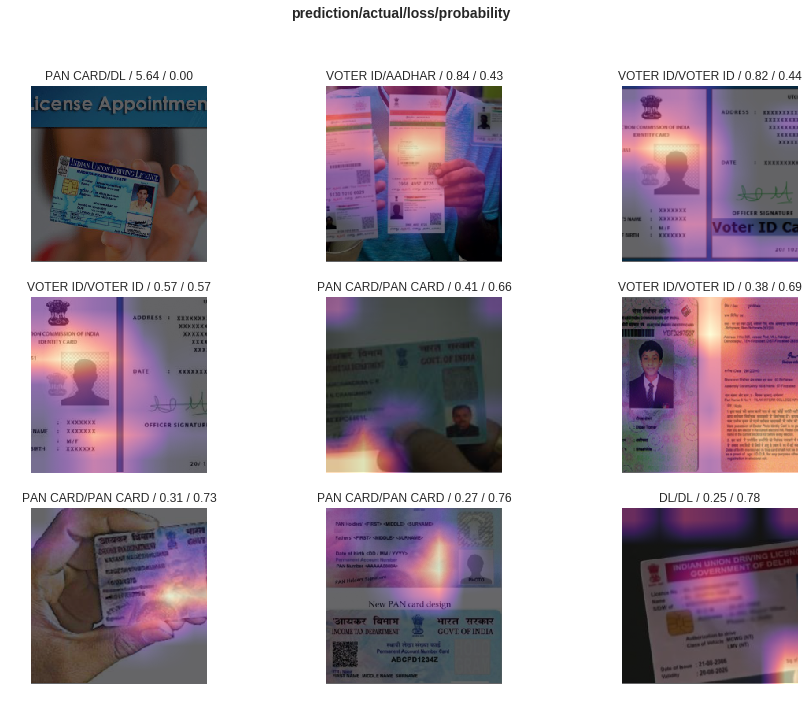

In [97]:
interp.plot_top_losses(9, figsize=(15,11)) # Prediction/ Actual/ Loss/ Probability

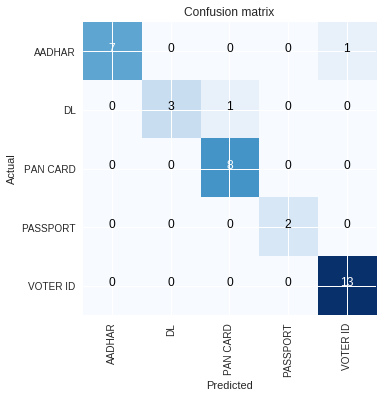

In [98]:
interp.plot_confusion_matrix()

##Try other architectures as well
Resnet 34
Resnet50
Resnet 101


In [105]:
learn34 = create_cnn(data, models.resnet34, metrics=accuracy)
learn34.fit_one_cycle(6) ## best way to fit as of 2018
print("learning complete")

epoch,train_loss,valid_loss,accuracy
1,2.050521,1.647939,0.171429
2,1.803475,1.316949,0.514286
3,1.387729,1.062488,0.600000
4,1.133009,0.862532,0.714286
5,0.951998,0.736758,0.714286
6,0.829946,0.655365,0.685714


learning complete


In [107]:
learn34.unfreeze()
learn34.fit_one_cycle(6, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy
1,0.202625,0.587191,0.771429
2,0.209826,0.459052,0.800000
3,0.182537,0.398863,0.885714
4,0.155453,0.350814,0.857143
5,0.144515,0.308914,0.914286
6,0.130917,0.259615,0.914286


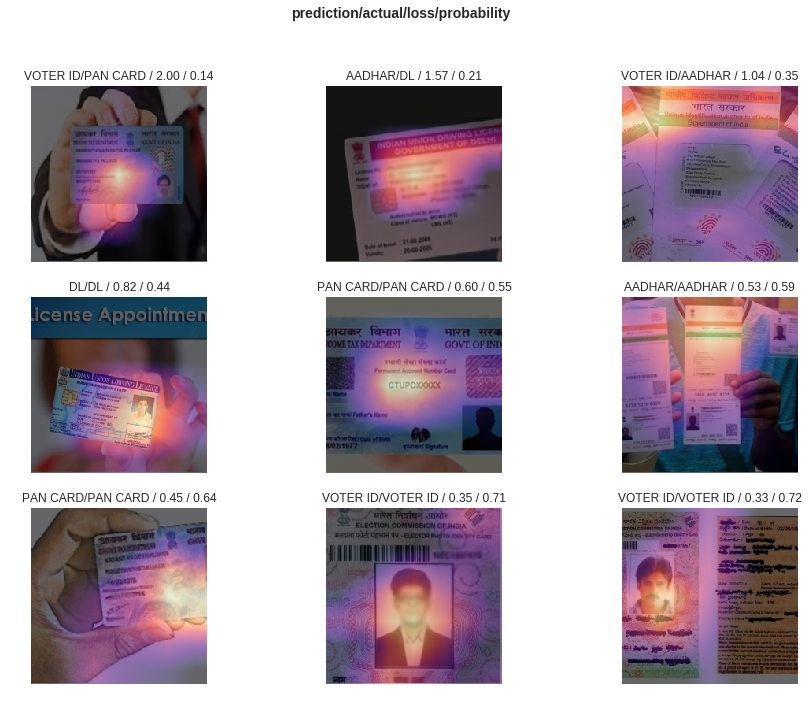

In [108]:
interp = ClassificationInterpretation.from_learner(learn34)
interp.plot_top_losses(9, figsize=(15,11)) # Prediction/ Actual/ Loss/ Probability

In [109]:
learn50 = create_cnn(data, models.resnet50, metrics=accuracy)
learn50.fit_one_cycle(6) ## best way to fit as of 2018
print("learning complete")

epoch,train_loss,valid_loss,accuracy
1,1.870702,1.553406,0.371429
2,1.329416,1.240618,0.657143
3,0.943701,1.009520,0.714286
4,0.715925,0.897570,0.771429
5,0.593102,0.787978,0.800000
6,0.512146,0.694639,0.800000


learning complete


In [110]:
learn50.unfreeze()
learn50.fit_one_cycle(6, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy
1,0.097498,0.607970,0.828571
2,0.091938,0.520756,0.828571
3,0.094429,0.647220,0.857143
4,0.077528,0.671155,0.857143
5,0.075105,0.629828,0.857143
6,0.066622,0.565029,0.857143


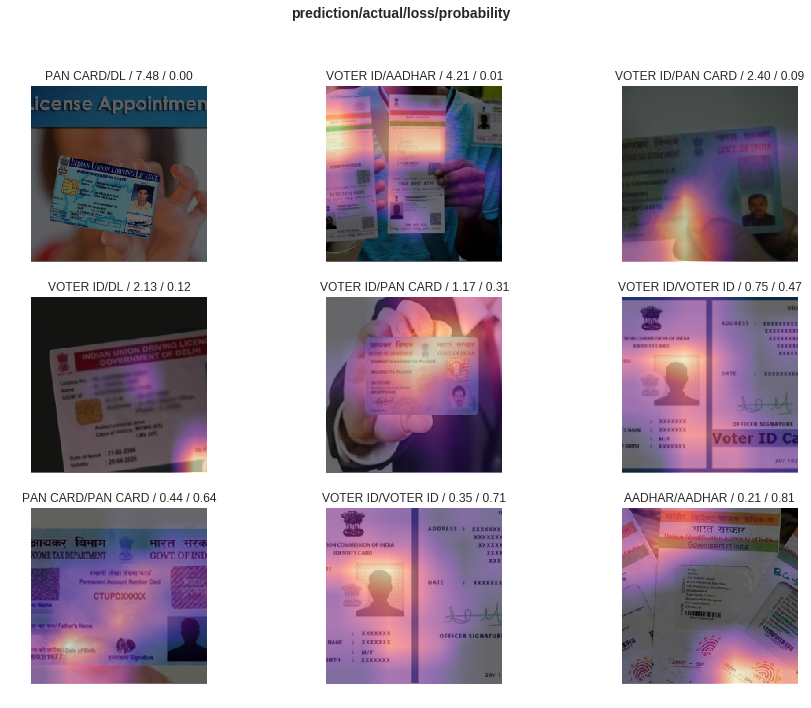

In [111]:
interp = ClassificationInterpretation.from_learner(learn50)
interp.plot_top_losses(9, figsize=(15,11)) # Prediction/ Actual/ Loss/ Probability

In [15]:
learn101 = create_cnn(data, models.resnet101, metrics=accuracy)
learn101.fit_one_cycle(6) ## best way to fit as of 2018
print("learning complete")

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.torch/models/resnet101-5d3b4d8f.pth
100%|██████████| 178728960/178728960 [00:09<00:00, 18722888.34it/s]


epoch,train_loss,valid_loss,accuracy
1,2.035333,1.573039,0.342857
2,1.416811,0.946901,0.657143
3,1.036275,0.711872,0.714286
4,0.803836,0.661597,0.714286
5,0.646977,0.580815,0.714286
6,0.549384,0.492925,0.800000


learning complete


In [16]:
learn101.unfreeze()
learn101.fit_one_cycle(6, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy
1,0.115576,0.378961,0.857143
2,0.079439,0.263445,0.914286
3,0.060799,0.171072,0.971429
4,0.048006,0.118165,0.971429
5,0.043160,0.079233,0.971429
6,0.039035,0.058237,0.971429


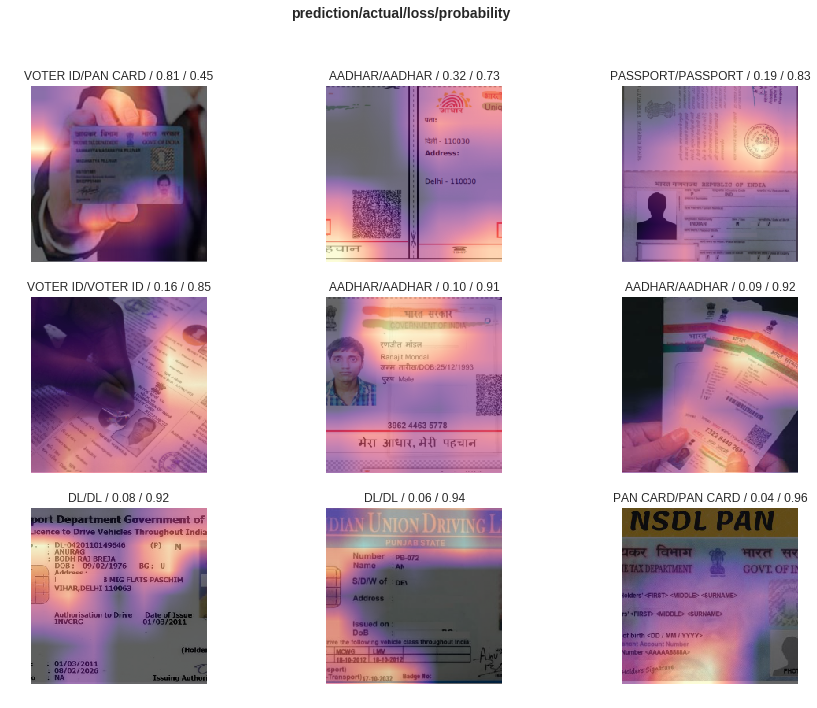

In [17]:
interp = ClassificationInterpretation.from_learner(learn101)
interp.plot_top_losses(9, figsize=(15,11)) # Prediction/ Actual/ Loss/ Probability



---

